In [1]:
!nvidia-smi

Fri Dec  5 08:39:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     On  |   00000000:01:00.0 Off |                  N/A |
| 32%   39C    P8             29W /  300W |       0MiB /  16303MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from IPython.display import clear_output

In [3]:
%pip install matplotlib
%pip install gdown
clear_output()
print("Packages downloaded.")

Packages downloaded.


In [4]:
!pip install gdown

In [ ]:
%%bash

WORKDIR=$(pwd)
DATASET_DIR="$WORKDIR/dataset"
DATASET_ZIP="$WORKDIR/dataset.zip"

if [ -d "$DATASET_DIR" ]; then
    echo "📁 Folder dataset sudah ada. Skip download & unzip."

elif [ -f "$DATASET_ZIP" ]; then
    echo "🗂️ ZIP ditemukan tanpa folder. Sedang di-unzip..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Unzip selesai."

else
    echo "⬇️ Download dataset dari Google Drive..."
    curl -L \
      -H "Authorization: Bearer TOKEN_SAYA" \
      "https://www.googleapis.com/drive/v3/files/1kaKoOooBB-r-TVsSIl_HZV6whnx7OFr8?alt=media" \
      -o "$DATASET_ZIP"

    echo "🛠️ Unzip dataset..."
    unzip -q "$DATASET_ZIP" -d "$DATASET_DIR"
    rm "$DATASET_ZIP"
    echo "✅ Selesai download & unzip."
fi

📁 Folder dataset sudah ada. Skip download & unzip.


In [6]:
import sys
print("Kernel Python:", sys.executable)

# upgrade pip/tooling
!{sys.executable} -m pip install --upgrade pip setuptools wheel

# common data / vision libs
!{sys.executable} -m pip install segmentation-models-pytorch pandas numpy matplotlib tqdm pillow opencv-python scikit-image scikit-learn scipy timm torchmetrics transformers accelerate tokenizers evaluate 

Kernel Python: /venv/main/bin/python


## Import Dependencies

In [7]:
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
from tqdm import tqdm
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_INP = "/workspace/dataset"
WORKDIR = "/workspace"
NUM_CLASSES = 11

print("DEVICE:", DEVICE)

DEVICE: cuda


## Dataset Loader

In [9]:
import glob
def get_sorted_paths(folder_path):
    files = sorted(glob.glob(os.path.join(folder_path, "*"))) 
    return files


train_image_paths = get_sorted_paths(ROOT_INP+'/train/train-org-img')
train_mask_paths = get_sorted_paths(ROOT_INP+'/train/train-label-img')

val_image_paths = get_sorted_paths(ROOT_INP+'/val/val-org-img')
val_mask_paths = get_sorted_paths(ROOT_INP+'/val/val-label-img')

test_image_paths = get_sorted_paths(ROOT_INP+'/test/test-org-img')
test_mask_paths = get_sorted_paths(ROOT_INP+'/test/test-label-img')

In [10]:
class RescueNetDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None, image_size=(512, 512)):
        self.image_path = image_path
        self.mask_path = mask_path
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        image = Image.open(self.image_path[idx]).convert('RGB')
        mask = Image.open(self.mask_path[idx]).convert('L')

        if self.transform:
            image = self.transform(image)

        mask = mask.resize(self.image_size, Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        # mask = np.clip(mask, 0, 9)
        mask = torch.from_numpy(mask).long()

        return image, mask

## Dataset Prep

In [11]:
train_test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

train_dataset = RescueNetDataset(train_image_paths, train_mask_paths, transform=train_test_transform)
val_dataset = RescueNetDataset(val_image_paths, val_mask_paths, transform=train_test_transform)
test_dataset = RescueNetDataset(test_image_paths, test_mask_paths, transform=train_test_transform)

BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=True)

In [12]:
# def get_all_unique_masks(dataloader, max_batches=None):
#     all_unique = set()
#     for i, (_, masks) in enumerate(dataloader):
#         all_unique.update(int(u) for u in torch.unique(masks))
#         if max_batches is not None and i+1 >= max_batches:
#             break
#     return sorted(all_unique)

# # print("Train unique (scan 200 batches):", get_all_unique_masks(train_loader, max_batches=200))
# # print("Val unique   (scan all):       ", get_all_unique_masks(val_loader))
# print("Test unique  (scan all):       ", get_all_unique_masks(test_loader))

## Modelling

In [13]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

model = smp.Segformer(
    encoder_name="mit_b1",       
    encoder_weights="imagenet",  
    in_channels=3,
    classes=11,                  
    activation=None              
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Train n Eval

In [14]:
print(f"Train Images: {len(train_image_paths)}, Train Masks: {len(train_mask_paths)}")
print(f"Val Images: {len(val_image_paths)}, Val Masks: {len(val_mask_paths)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE USED : {device}")

Train Images: 3595, Train Masks: 3595
Val Images: 449, Val Masks: 449
DEVICE USED : cuda


In [15]:
class JointLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)

    def forward(self, logits, targets):
        loss_ce = self.ce(logits, targets)
        loss_dice = self.dice(logits, targets)
        return loss_ce + loss_dice

total_loss_fn = JointLoss()

encoder_params = []
decoder_params = []

for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    
    if name.startswith("encoder"):
        encoder_params.append(param)
    else:
        decoder_params.append(param)

optimizer = AdamW(
    [
    {'params': encoder_params, 'lr': 6e-4},  
    {'params': decoder_params, 'lr': 9e-3}   
], 
    # model.parameters(),
    weight_decay=1e-2)    
    # lr=6e-4)

In [16]:
from torchmetrics import JaccardIndex
from tqdm.auto import tqdm

# EPOCHS = 1

EPOCHS = 25
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    eta_min=1e-6 
)

metric_val   = JaccardIndex(task="multiclass", num_classes=11, average=None).to(device)

best_mIoU = 0.0

history = {
    "train_loss": [],
    "val_loss": [],
    "val_miou": []
}

for epoch in range(EPOCHS):

    model.train()
    train_loss = 0

    if hasattr(model, 'mod1_detection'): 
        model.mod1_detection.eval()
        
    for images, masks in tqdm(train_loader, desc=f"Train {epoch+1}/{EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = total_loss_fn(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        del preds, loss
        torch.cuda.empty_cache()

    train_loss /= len(train_loader)

    print(f"🎯 Train Loss: {train_loss:.4f}")
    history["train_loss"].append(train_loss)

    model.eval()
    val_loss = 0
    metric_val.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Val {epoch+1}/{EPOCHS}"):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = total_loss_fn(preds, masks)
            val_loss += loss.item()

            pred_mask = preds.argmax(dim=1)
            metric_val.update(pred_mask, masks)

            del preds, loss
            torch.cuda.empty_cache()

    val_loss /= len(val_loader)
    iou_val_per_class = metric_val.compute()
    mIoU_val = iou_val_per_class.mean().item()

    history["val_loss"].append(val_loss)
    history["val_miou"].append(mIoU_val)

    print(f"""
============================== Epoch: {epoch+1}/{EPOCHS}
Train Loss: {train_loss:.4f}
Val Loss:   {val_loss:.4f}   | Val mIoU: {mIoU_val:.4f}
==============================
""")


    scheduler.step(val_loss)

    if best_mIoU < mIoU_val:
        best_mIoU = mIoU_val
        torch.save(model.state_dict(), "best_model_segformer.pth")
        print("Model disimpan (best so far).")
            
print("Training Selesai!")

Train 1/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 1.3752


Val 1/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 1/25
Train Loss: 1.3752
Val Loss:   0.9986   | Val mIoU: 0.4493

Model disimpan (best so far).


Train 2/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.9757


Val 2/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 2/25
Train Loss: 0.9757
Val Loss:   0.9194   | Val mIoU: 0.4970

Model disimpan (best so far).


Train 3/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8558


Val 3/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 3/25
Train Loss: 0.8558
Val Loss:   0.8187   | Val mIoU: 0.5154

Model disimpan (best so far).


Train 4/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.8033


Val 4/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 4/25
Train Loss: 0.8033
Val Loss:   0.8502   | Val mIoU: 0.5062



Train 5/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7563


Val 5/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 5/25
Train Loss: 0.7563
Val Loss:   0.7780   | Val mIoU: 0.5390

Model disimpan (best so far).


Train 6/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.7356


Val 6/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 6/25
Train Loss: 0.7356
Val Loss:   0.7837   | Val mIoU: 0.5409

Model disimpan (best so far).


Train 7/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.6932


Val 7/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 7/25
Train Loss: 0.6932
Val Loss:   0.8043   | Val mIoU: 0.5587

Model disimpan (best so far).


Train 8/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.6713


Val 8/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 8/25
Train Loss: 0.6713
Val Loss:   0.8080   | Val mIoU: 0.5690

Model disimpan (best so far).


Train 9/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.6425


Val 9/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 9/25
Train Loss: 0.6425
Val Loss:   0.7642   | Val mIoU: 0.5745

Model disimpan (best so far).


Train 10/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.6101


Val 10/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 10/25
Train Loss: 0.6101
Val Loss:   0.7673   | Val mIoU: 0.5609



Train 11/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.6135


Val 11/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 11/25
Train Loss: 0.6135
Val Loss:   0.6894   | Val mIoU: 0.6044

Model disimpan (best so far).


Train 12/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.5731


Val 12/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 12/25
Train Loss: 0.5731
Val Loss:   0.7850   | Val mIoU: 0.5602



Train 13/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.5652


Val 13/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 13/25
Train Loss: 0.5652
Val Loss:   0.7840   | Val mIoU: 0.5549



Train 14/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.5607


Val 14/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 14/25
Train Loss: 0.5607
Val Loss:   0.7371   | Val mIoU: 0.5972



Train 15/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.5015


Val 15/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 15/25
Train Loss: 0.5015
Val Loss:   0.8321   | Val mIoU: 0.5586



Train 16/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4891


Val 16/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 16/25
Train Loss: 0.4891
Val Loss:   0.7212   | Val mIoU: 0.6107

Model disimpan (best so far).


Train 17/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4733


Val 17/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 17/25
Train Loss: 0.4733
Val Loss:   0.7668   | Val mIoU: 0.6054



Train 18/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4617


Val 18/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 18/25
Train Loss: 0.4617
Val Loss:   0.7744   | Val mIoU: 0.5922



Train 19/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4469


Val 19/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 19/25
Train Loss: 0.4469
Val Loss:   0.7660   | Val mIoU: 0.5940



Train 20/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4471


Val 20/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 20/25
Train Loss: 0.4471
Val Loss:   0.7488   | Val mIoU: 0.5918



Train 21/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4243


Val 21/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 21/25
Train Loss: 0.4243
Val Loss:   0.7509   | Val mIoU: 0.5911



Train 22/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4223


Val 22/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 22/25
Train Loss: 0.4223
Val Loss:   0.7470   | Val mIoU: 0.6028



Train 23/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4082


Val 23/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 23/25
Train Loss: 0.4082
Val Loss:   0.8086   | Val mIoU: 0.6022



Train 24/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.4131


Val 24/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 24/25
Train Loss: 0.4131
Val Loss:   0.7962   | Val mIoU: 0.5786



Train 25/25:   0%|          | 0/449 [00:00<?, ?it/s]

🎯 Train Loss: 0.3938


Val 25/25:   0%|          | 0/56 [00:00<?, ?it/s]


============================== Epoch: 25/25
Train Loss: 0.3938
Val Loss:   0.7879   | Val mIoU: 0.5927

Training Selesai!


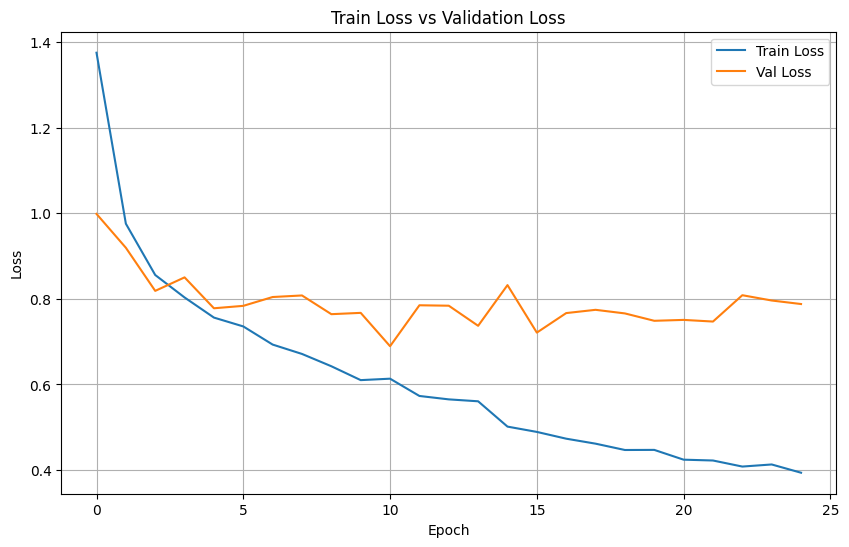

In [17]:
import matplotlib.pyplot as plt

# Plot Train Loss vs Val Loss
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Train Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import json

output_path = WORKDIR+"/history_segformer.json"

with open(output_path, "w") as f:
    json.dump(history, f, indent=4)

print("File saved to:", output_path)

File saved to: /workspace/history_segformer.json


## Testing

In [19]:
import torch
from tqdm.auto import tqdm
from torchmetrics import JaccardIndex  

def test_model(model, test_loader, device):
    metric = JaccardIndex(
        task="multiclass", 
        num_classes=NUM_CLASSES, 
        ignore_index=255,
        average="none" 
    ).to(device)

    model.to(device)
    
    model.eval()
    test_loss = 0.0
    print("Mulai Testing (menggunakan JaccardIndex)...")
    
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            
            loss = total_loss_fn(preds, masks)
            test_loss += loss.item()

            pred_mask = torch.argmax(preds, dim=1)
            metric.update(pred_mask, masks)
    
    iou_per_class = metric.compute()
    
    mIoU = iou_per_class.mean().item()
    
    print("\n=== HASIL TESTING ===")
    print(f"Mean IoU (mIoU): {mIoU:.4f}")
    print("-" * 30)
    
    class_names = [
        "Background", "Water", "Building No Damage", "Building Minor Damage", 
        "Building Major Damage", "Building Total Destruction", "Road-Clear", 
        "Road-Blocked", "Vehicle", "Tree", "Pool"
    ]
    
    for i, iou in enumerate(iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")
        
    metric.reset()
    return mIoU, iou_per_class

In [20]:
import torch
import numpy as np
import torch.nn.functional as F

NUM_CLASSES = 11
model = smp.Segformer(
    encoder_name="mit_b1",       
    encoder_weights="imagenet",  
    in_channels=3,
    classes=11,                  
    activation=None              
)
# /kaggle/input/segformer/pytorch/default/1
TMP_DIR = "/workspace"

ckpt_path = TMP_DIR + "/best_model_segformer.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

if isinstance(ckpt, dict):
    if "model_state_dict" in ckpt:
        ckpt_state = ckpt["model_state_dict"]
    elif "state_dict" in ckpt:
        ckpt_state = ckpt["state_dict"]
    elif "model" in ckpt:
        ckpt_state = ckpt["model"]
    else:
        ckpt_state = ckpt
else:
    ckpt_state = ckpt

try:
    model.load_state_dict(ckpt_state)
    print("Checkpoint loaded with strict=True (perfect match).")
except Exception as e:
    print("Strict load failed:", e)
    model_state = model.state_dict()
    compatible = {}
    mismatched = []
    for k, v in ckpt_state.items():
        if k in model_state:
            if v.shape == model_state[k].shape:
                compatible[k] = v
            else:
                mismatched.append((k, v.shape, model_state[k].shape))
    print(f"Compatible keys: {len(compatible)} / {len(model_state)}")
    if mismatched:
        print("Mismatched params (name, ckpt_shape, model_shape) - top 10 shown:")
        for item in mismatched[:10]:
            print(" ", item)
    model_state.update(compatible)
    model.load_state_dict(model_state)
    print("Loaded compatible weights; mismatched layers left as randomly initialized.")

Checkpoint loaded with strict=True (perfect match).


In [21]:
class_names = [
        "Background", "Water", "Building No Damage", "Building Minor Damage", 
        "Building Major Damage", "Building Total Destruction", "Road-Clear", 
        "Road-Blocked", "Vehicle", "Tree", "Pool"
    ]

test_mIoU, test_iou_per_class = test_model(model, test_loader, device)

print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n")
print(f"===================== Hasil Testing mIoU {test_mIoU} ========================\n\n\n")
print(f"===================== IoU Per Class ========================")
for i, iou in enumerate(test_iou_per_class):
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        print(f"{name:25s}: {iou.item():.4f}")


Mulai Testing (menggunakan JaccardIndex)...


Testing:   0%|          | 0/56 [00:00<?, ?it/s]


=== HASIL TESTING ===
Mean IoU (mIoU): 0.5921
------------------------------
Background               : 0.8013
Water                    : 0.7938
Building No Damage       : 0.5781
Building Minor Damage    : 0.4800
Building Major Damage    : 0.4839
Building Total Destruction: 0.5253
Road-Clear               : 0.5262
Road-Blocked             : 0.6959
Vehicle                  : 0.3457
Tree                     : 0.7821
Pool                     : 0.5013
===================== Hasil Testing mIoU 0.5921399593353271 ========================

===================== Hasil Testing mIoU 0.5921399593353271 ========================

===================== Hasil Testing mIoU 0.5921399593353271 ========================

===================== Hasil Testing mIoU 0.5921399593353271 ========================

===================== Hasil Testing mIoU 0.5921399593353271 ========================



===================== IoU Per Class ========================
Background               : 0.8013
Water               

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# import os
# from matplotlib.patches import Patch

# CLASS_NAMES = [
#     "Background",               
#     "Water",                    
#     "Building No Damage",       
#     "Building Minor Damage",    
#     "Building Major Damage",    
#     "Building Total Destruction",
#     "Road-Clear",               
#     "Road-Blocked",             
#     "Vehicle",                  
#     "Tree",                     
#     "Pool"                      
# ]

# LABEL_COLORS = np.array([
#     [0, 0, 0],         # Background 
#     [30, 230, 255],    # Water 
#     [184, 115, 117],   # Building No Damage
#     [216, 255, 0],     # Building Minor Damage
#     [252, 199, 0],     # Building Major Damage
#     [255, 0, 0],       # Building Total Destruction
#     [140, 140, 140],   # Road-Clear
#     [151, 0, 255],     # Road-Blocked
#     [255, 0, 246],     # Vehicle 
#     [0, 255, 0],       # Tree
#     [244, 255, 0]      # Pool
# ])
# def decode_segmap(mask):
#     r = np.zeros_like(mask).astype(np.uint8)
#     g = np.zeros_like(mask).astype(np.uint8)
#     b = np.zeros_like(mask).astype(np.uint8)
    
#     for l in range(0, len(LABEL_COLORS)):
#         idx = mask == l
#         r[idx] = LABEL_COLORS[l, 0]
#         g[idx] = LABEL_COLORS[l, 1]
#         b[idx] = LABEL_COLORS[l, 2]
        
#     rgb = np.stack([r, g, b], axis=2)
#     return rgb

# def find_indices_by_filename(dataset, target_ids):
#     found_indices = []
#     for target in target_ids:
#         found = False
#         for idx, path in enumerate(dataset.image_path):
#             if str(target) in os.path.basename(path):
#                 found_indices.append(idx)
#                 found = True
#                 break
#         if not found:
#             return 
#     return found_indices

# def visualize_specific_images(model, dataset, target_ids, device, processor):
#     model.eval()
    
#     indices = find_indices_by_filename(dataset, target_ids)

#     num_samples = len(indices)
#     fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))
    
#     if num_samples == 1:
#         axes = axes.reshape(1, -1)

#     for row_idx, idx in enumerate(indices):
#         image, mask = dataset[idx] 
        
#         filename = os.path.basename(dataset.image_path[idx])
        
#         inputs = processor(
#             images=[image], 
#             return_tensors="pt",
#             do_resize=False, 
#             do_rescale=False
#         )
#         inputs = {k: v.to(device) for k, v in inputs.items()}
        
#         with torch.no_grad():
#             outputs = model(**inputs)
        
#         target_sizes = [(mask.shape[0], mask.shape[1])]
#         pred_map = processor.post_process_semantic_segmentation(
#             outputs, target_sizes=target_sizes
#         )[0] 
        
#         img_np = image.permute(1, 2, 0).numpy()
        
#         mask_rgb = decode_segmap(mask.numpy())
#         pred_rgb = decode_segmap(pred_map.cpu().numpy())
        
#         axes[row_idx, 0].imshow(img_np)
#         axes[row_idx, 0].set_title(f"ID: {filename}\nOriginal Image")
#         axes[row_idx, 0].axis("off")
        
#         axes[row_idx, 1].imshow(mask_rgb)
#         axes[row_idx, 1].set_title("Ground Truth")
#         axes[row_idx, 1].axis("off")
        
#         axes[row_idx, 2].imshow(pred_rgb)
#         axes[row_idx, 2].set_title("Mask2Former Prediction")
#         axes[row_idx, 2].axis("off")

#     handles = [Patch(color=LABEL_COLORS[i]/255.0, label=CLASS_NAMES[i]) for i in range(len(CLASS_NAMES))]
#     fig.legend(handles=handles, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0.0), fontsize=12)

#     plt.savefig('visualisasi_prediksi_rescuenet.png', bbox_inches='tight', dpi=300)
    
#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.08) 
#     plt.show()

# target_ids = ["10794", "10801", "10807"]

# visualize_specific_images(model, test_dataset, target_ids, device, processor)

In [23]:
# model.eval()
# import matplotlib.pyplot as plt

# test_imgs, test_masks = next(iter(test_loader))

# with torch.no_grad():
#     inputs = [{"image": test_imgs[0].to(cfg.MODEL.DEVICE), "height": 512, "width": 512}]
    
#     outputs = model(inputs)
    
#     pred_mask = outputs[0]["sem_seg"].argmax(dim=0).cpu().numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1); plt.title("Prediction"); plt.imshow(pred_mask)
# plt.subplot(1, 2, 2); plt.title("Ground Truth"); plt.imshow(test_masks[0])
# plt.show()